# PROJECT TITLE "TOUCH AND USER CLASSİFİCATİON FROM SMART FABRİC"

# Name Surname: Esra Aydın Student ID: 211805079

In [1]:
import joblib
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, 
                             confusion_matrix, make_scorer)

In [2]:
from datetime import datetime
print("Date:", datetime.today().strftime('%Y-%m-%d'))

Date: 2025-04-19


In [3]:
file_path = r"C:\Users\esra\Downloads\ML_Midterm\03-Touch and User Classification from Smart Fabric.xlsx"
df = pd.read_excel(file_path)

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
check_df(df)    

##################### Shape #####################
(2056, 3206)
##################### Types #####################
user_id       int64
touch_type    int64
touch          bool
finger         bool
palm           bool
              ...  
3196          int64
3197          int64
3198          int64
3199          int64
3200          int64
Length: 3206, dtype: object
##################### Head #####################
   user_id  touch_type  touch  finger   palm   fist   1  2   3   4  ...  3191  \
0        0           0  False   False  False  False   4  0  12 -16  ...   -51   
1        0           0  False   False  False  False -52 -2  17   1  ...   -36   
2        0           0  False   False  False  False   2  7  14  -5  ...     1   
3        0           0  False   False  False  False   0  6  10   8  ...     1   
4        0           0  False   False  False  False   2  5   3   0  ...   -25   

   3192  3193  3194  3195  3196  3197  3198  3199  3200  
0     4     1     3   -42     2     3    61  

# Cross-Correlation 

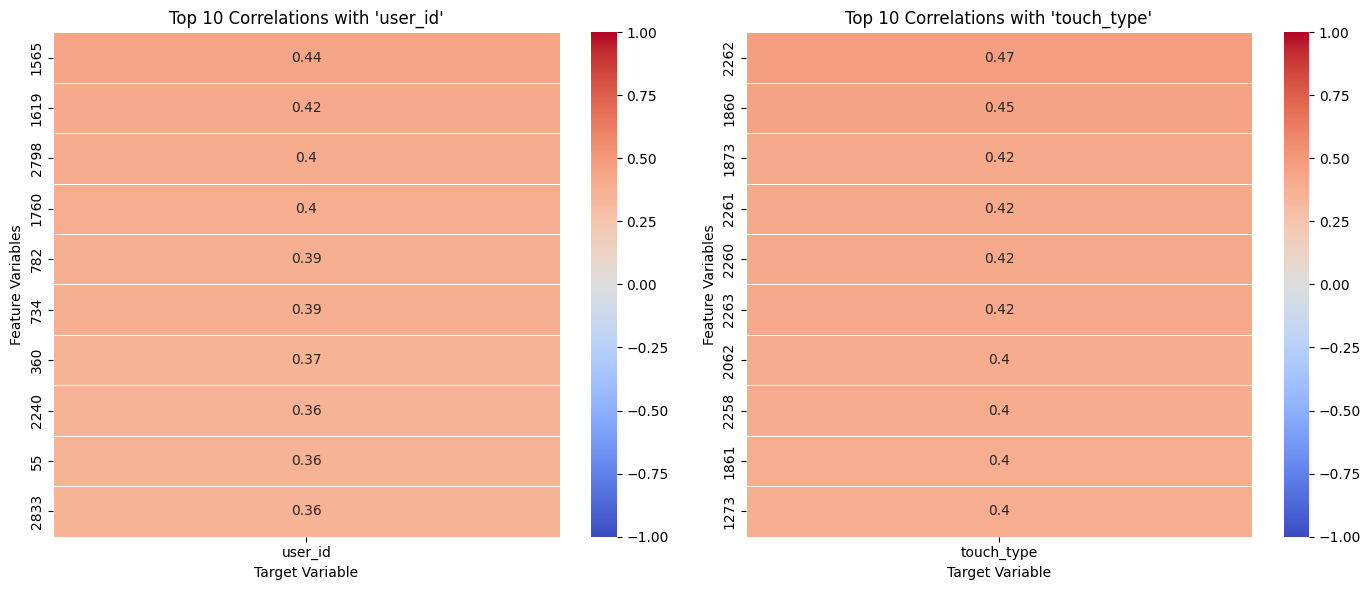

In [14]:
# Drop unused columns
dff = df.drop(columns=["touch", "finger", "palm", "fist"])
numeric_df = dff.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
targets = ['user_id', 'touch_type']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i, target in enumerate(targets):
    # Get top 10 most correlated features with the target
    top_10_corr = corr_matrix[target].drop(target).sort_values(ascending=False).head(10)

    # Prepare heatmap data
    heatmap_data = corr_matrix.loc[top_10_corr.index, [target]]

    # Plot heatmap
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
                linewidths=0.5, cbar=True, ax=axes[i])
    axes[i].set_title(f"Top 10 Correlations with '{target}'", fontsize=12)
    axes[i].set_xlabel("Target Variable")
    axes[i].set_ylabel("Feature Variables")
plt.tight_layout()
plt.show()

# Preprocessing And Feature Engineering

In [16]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns
na_columns = missing_values_table(dff, na_name=True) 

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [19]:
zero_counts = (dff == 0).sum()  # How many 0s are there in which column?
zero_counts = zero_counts[zero_counts > 0]  # Get columns containing only 0
print(zero_counts)

user_id         85
touch_type    1144
1              153
2              108
3              107
              ... 
3196           116
3197            88
3198           110
3199           115
3200           123
Length: 3202, dtype: int64


In [20]:
cols_to_replace = dff.columns.difference(['user_id', 'touch_type'])
dff[cols_to_replace] = dff[cols_to_replace].replace(0, np.nan)
na_columns = missing_values_table(dff, na_name=True)

      n_miss  ratio
123      478  23.25
1123     466  22.67
126      463  22.52
1723     441  21.45
323      440  21.40
...      ...    ...
851       12   0.58
1242      11   0.54
1465      11   0.54
2465      11   0.54
2260       8   0.39

[3200 rows x 2 columns]


In [23]:
#Determine if more than 10% of the columns have missing values.
dff.columns = dff.columns.astype(str)
high_missing_columns = [col for col in dff.columns if (dff[col].isnull().sum() / len(dff)) * 100 > 10]
dff = dff.drop(columns=high_missing_columns)

#Fill in the missing values in the remaining columns with the median
imputer = SimpleImputer(strategy='median')
dff[:] = imputer.fit_transform(dff)
na_columns = missing_values_table(dff, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [24]:
def outlier_thresholds(dataframe, col_name, q1=0.1, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [25]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
for col in dff.columns:
    if check_outlier(dff,col):
       print(col)   

330
362
562
840
962
1004
1162
1311
1362
1426
1649
1651
1653
1654
1655
1656
1657
1658
1659
1660
1673
1687
1762
1806
1807
1828
1833
1896
1930
2054
2055
2056
2057
2058
2088
2207
2302
2403
2406
2417
2426
2452
2454
2455
2456
2457
2458
2459
2460
2461
2482
2488
2489
2536
2854
2855
2856
2858
2859
2888
3052
3054


In [36]:
def replace_with_thresholds(dataframe, variable, q1=0.1, q3=0.90):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.1, q3=0.90)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
outlier_columns = []
# Aykırı Değer Analizi ve Baskılama İşlemi
for col in dff.columns:
    if check_outlier(dff, col):
        outlier_columns.append(col)
        replace_with_thresholds(dff, col)    
na_colums = missing_values_table(dff,na_name=True)        

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


# Machine Learning ,Evalution & Model Selection

In [57]:
# Function to evaluate different models and parameter configurations
def evaluate_models(X_train, X_test, y_train, y_test, models):
    """
    This function trains each model with different parameter settings
    and returns evaluation metrics and the best model based on accuracy.
    """
    results = []
    best_overall = {"model_name": None, "config": None, "accuracy": 0, "estimator": None}

    # Loop through each model and parameter configuration
    for model_name, model_info in models.items():
        base_estimator = model_info["estimator"]
        
        for param_config in model_info["params"]:
            # Set hyperparameters
            estimator = base_estimator.set_params(**param_config)
            estimator.fit(X_train, y_train)
            y_pred = estimator.predict(X_test)
            
            # Compute evaluation metrics
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            rec = recall_score(y_test, y_pred, average='weighted')
             
            # Save the results
            results.append({
                "Model": model_name,
                "Parameters": str(param_config),
                "Accuracy": acc,
                "F1": f1,
                "Precision": prec,
                "Recall": rec,
            })
            
            # Track the best model based on accuracy
            if acc > best_overall["accuracy"]:
                best_overall.update({
                    "model_name": model_name,
                    "config": param_config,
                    "accuracy": acc,
                    "estimator": estimator
                })
    
    return results, best_overall

In [58]:
# Define models and their parameter configurations
models = {
    "DecisionTree": {
        "estimator": DecisionTreeClassifier(random_state=42),
        "params": [
            {"max_depth": 3},
            {"max_depth": 5},
            {"max_depth": None}
        ]
    },
    "LogisticRegression": {
        "estimator": LogisticRegression(solver='liblinear', random_state=42),
        "params": [
            {"C": 0.1},
            {"C": 1},
            {"C": 10}
        ]
    },
    "KNN": {
        "estimator": KNeighborsClassifier(),
        "params": [
            {"n_neighbors": 3},
            {"n_neighbors": 5},
            {"n_neighbors": 7}
        ]
    },
    "MLP": {
        "estimator": MLPClassifier(max_iter=300, random_state=42),
        "params": [
            {"hidden_layer_sizes": (50,)},
            {"hidden_layer_sizes": (100,)},
            {"hidden_layer_sizes": (50, 50)}
        ]
    }
}

In [59]:
# Function to evaluate all models for multiple target variables
def evaluate_for_targets(df, target_list, models):
    """
    This function loops over each target variable, splits and scales the data,
    evaluates all models, and stores the results.
    """
    all_results = {}

    for target in target_list:
        print(f"\n--- Evaluating Target: {target} ---")
        
        # Prepare features and labels
        X = df.drop(columns=[target])
        y = df[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        results, best = evaluate_models(X_train, X_test, y_train, y_test, models)
        all_results[target] = {
            "all": results,
            "best": best
        }
        for result in results:
            print(result)

        print("\nBest model for", target)
        print(best)

    return all_results

targets = ["user_id", "touch_type"]  # Add as many target variables as you want
all_model_results = evaluate_for_targets(dff, targets, models)


--- Evaluating Target: user_id ---
{'Model': 'DecisionTree', 'Parameters': "{'max_depth': 3}", 'Accuracy': 0.1312803889789303, 'F1': 0.10923372513140131, 'Precision': 0.13323686038434823, 'Recall': 0.1312803889789303}
{'Model': 'DecisionTree', 'Parameters': "{'max_depth': 5}", 'Accuracy': 0.22852512155591573, 'F1': 0.18073542776146248, 'Precision': 0.23657641661505757, 'Recall': 0.22852512155591573}
{'Model': 'DecisionTree', 'Parameters': "{'max_depth': None}", 'Accuracy': 0.8654781199351702, 'F1': 0.8663443546155379, 'Precision': 0.8756589298635361, 'Recall': 0.8654781199351702}
{'Model': 'LogisticRegression', 'Parameters': "{'C': 0.1}", 'Accuracy': 1.0, 'F1': 1.0, 'Precision': 1.0, 'Recall': 1.0}
{'Model': 'LogisticRegression', 'Parameters': "{'C': 1}", 'Accuracy': 1.0, 'F1': 1.0, 'Precision': 1.0, 'Recall': 1.0}
{'Model': 'LogisticRegression', 'Parameters': "{'C': 10}", 'Accuracy': 1.0, 'F1': 1.0, 'Precision': 1.0, 'Recall': 1.0}
{'Model': 'KNN', 'Parameters': "{'n_neighbors': 3}",

# Visualize the Metric Results

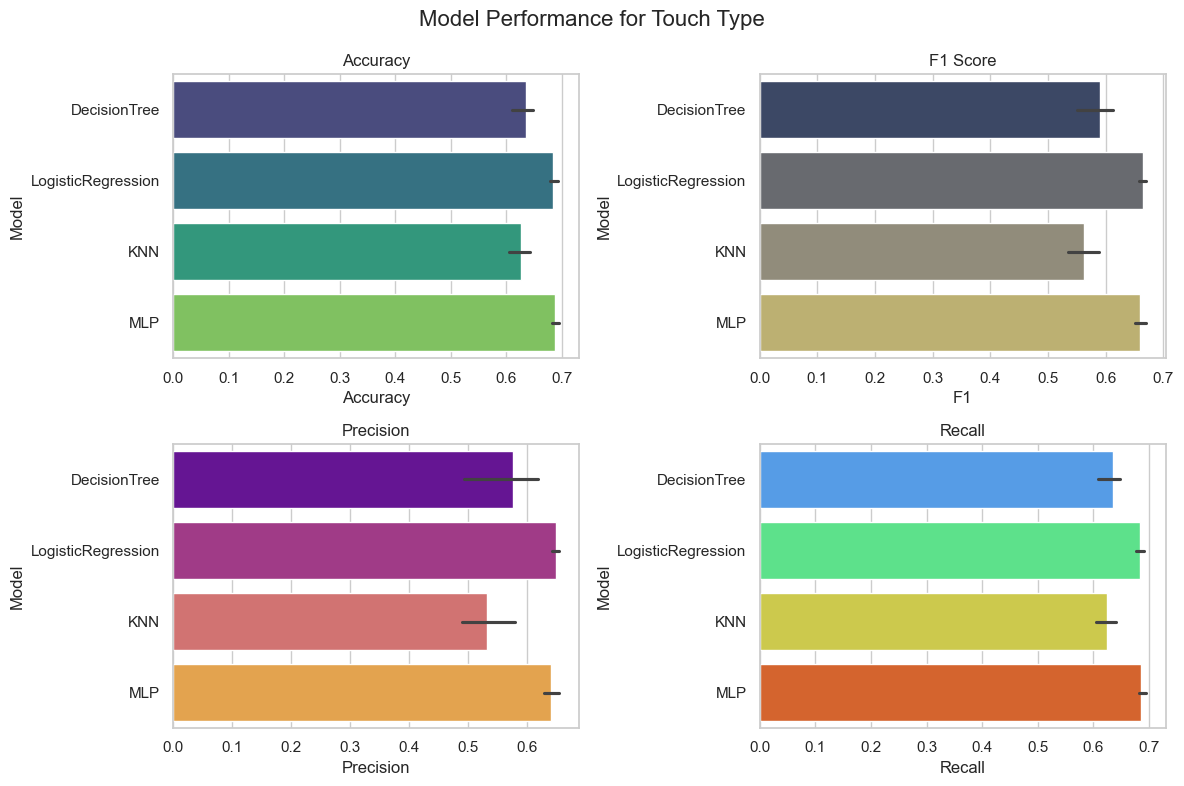

In [69]:
def visualize_touch_type_metrics(all_model_results):
    """
    Visualizes the accuracy, F1, Precision, and Recall for models under the 'touch_type' category.
    """
    # Extract data for the touch_type
    touch_type_data = all_model_results['touch_type']['all']
    
    # Prepare a DataFrame for the metrics visualization
    metrics_data = []
    for result in touch_type_data:
        metrics_data.append({
            "Model": result["Model"],
            "Accuracy": result["Accuracy"],
            "F1": result["F1"],
            "Precision": result["Precision"],
            "Recall": result["Recall"],
            "Parameters": result["Parameters"]
        })
    
    # Convert to DataFrame for easy manipulation
    df_metrics = pd.DataFrame(metrics_data)
    
    # Set up seaborn style
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Model Performance for Touch Type', fontsize=16)
    sns.barplot(x="Accuracy", y="Model", data=df_metrics, ax=axes[0, 0], hue='Model', palette="viridis", legend=False)
    axes[0, 0].set_title("Accuracy")
    sns.barplot(x="F1", y="Model", data=df_metrics, ax=axes[0, 1], hue='Model', palette="cividis", legend=False)
    axes[0, 1].set_title("F1 Score")
    sns.barplot(x="Precision", y="Model", data=df_metrics, ax=axes[1, 0], hue='Model', palette="plasma", legend=False)
    axes[1, 0].set_title("Precision")
    sns.barplot(x="Recall", y="Model", data=df_metrics, ax=axes[1, 1], hue='Model', palette="turbo", legend=False)
    axes[1, 1].set_title("Recall")

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust the top space to accommodate the title
    plt.show()
visualize_touch_type_metrics(all_model_results)

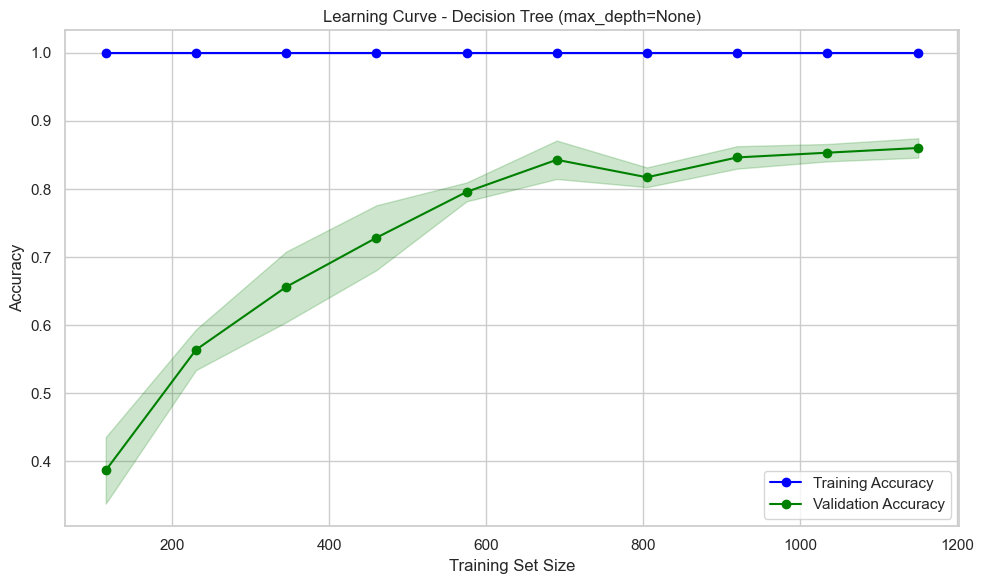

In [60]:
from sklearn.model_selection import learning_curve
# Özellikler ve hedef
X = dff.drop(columns=["user_id"])
y = dff["user_id"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model
estimator = DecisionTreeClassifier(max_depth=None, random_state=42)

# calculate Learning curve
train_sizes, train_scores, test_scores = learning_curve(estimator, X_train_scaled, y_train,
                                                        cv=5,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        scoring='accuracy',
                                                        shuffle=True,
                                                        random_state=42)

# mean ve std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")

plt.plot(train_sizes, test_mean, 'o-', color="green", label="Validation Accuracy")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="green")

plt.title("Learning Curve - Decision Tree (max_depth=None)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# 🧩 Hyperparameter Tuning 'user_id'

In [61]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator, X, y, cv=5)
print("Average accuracy:", scores.mean())

Average accuracy: 0.8959098103134672


In [62]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid.fit(X, y)

print("Best parameters:", grid.best_params_)
print("Best cross-val score:", grid.best_score_)

Best parameters: {'max_depth': None, 'min_samples_split': 2}
Best cross-val score: 0.8959098103134672


# 🧩 Hyperparameter Tuning 'touch_type'

In [63]:
def hyperparameter_tuning(X_train, y_train, model_name):
    """
    This function performs hyperparameter tuning using GridSearchCV
    based on the given model name.
    """
    # Define the grid for the model based on its name
    if model_name == "DecisionTree":
        grid = {
            "max_depth": [None, 3, 5, 7, 10],
            "min_samples_split": [2, 5, 10]
        }
        estimator = DecisionTreeClassifier(random_state=42)
    elif model_name == "LogisticRegression":
        grid = {
            "C": [0.01, 0.1, 1, 10, 100],
            "penalty": ['l1', 'l2']
        }
        estimator = LogisticRegression(solver='liblinear', random_state=42)
    elif model_name == "KNN":
        grid = {
            "n_neighbors": [1, 3, 5, 7, 9],
            "weights": ['uniform', 'distance']
        }
        estimator = KNeighborsClassifier()
    elif model_name == "MLP":
        grid = {
            "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
            "alpha": [0.0001, 0.001, 0.01]
        }
        estimator = MLPClassifier(max_iter=300, random_state=42)
    else:
        print("Model not supported!")
        return None, None, None

    # Perform Grid Search with cross-validation
    print("\nPerforming Grid Search with parameters:", grid)
    grid_search = GridSearchCV(estimator, grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Print the best parameters and best score
    print("\nGrid Search Results:")
    print("Best parameters:", grid_search.best_params_)
    print("Best CV Accuracy:", grid_search.best_score_)

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

model_name = "MLP"  # You can manually choose the model here
best_model, best_params, best_score = hyperparameter_tuning(X_train, y_train, model_name)

# you can now test this best model on the test data
y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with Best Model: {test_acc}")


Performing Grid Search with parameters: {'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)], 'alpha': [0.0001, 0.001, 0.01]}

Grid Search Results:
Best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
Best CV Accuracy: 0.9993031358885018
Test Accuracy with Best Model: 0.9983792544570502


In [72]:
# Test verisi üzerinde tahmin yapalım
y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with Best Model: {test_acc}")

Test Accuracy with Best Model: 0.9983792544570502


# Saving the Model

In [73]:
# En iyi modeli kaydedelim
model_filename = "best_model.pkl"  # Modeli kaydetmek için dosya adı
joblib.dump(best_model, model_filename)
print(f"Model başarıyla kaydedildi: {model_filename}")

Model başarıyla kaydedildi: best_model.pkl


# Model Deployment

In [74]:
# Kaydedilen modeli yükleyip test edebiliriz
loaded_model = joblib.load(model_filename)
y_pred_loaded = loaded_model.predict(X_test)

# Testing with Test Data & Showing Predictions

In [77]:
# Test performance with the loaded model
final_acc = accuracy_score(y_test, y_pred_loaded)
print(f"Loaded model test accuracy: {final_acc}")

# Comparison of predicted results with actual labels
print("\nReal values (True labels) vs Predictions:")
comparison = list(zip(y_test, y_pred_loaded)) 
for real, pred in comparison[:10]:  # First 10
    print(f"True: {real}, Predicted: {pred}")

Loaded model test accuracy: 0.9983792544570502

Real values (True labels) vs Predictions:
True: 21, Predicted: 21
True: 21, Predicted: 21
True: 3, Predicted: 3
True: 4, Predicted: 4
True: 18, Predicted: 18
True: 5, Predicted: 5
True: 8, Predicted: 8
True: 16, Predicted: 16
True: 11, Predicted: 11
True: 23, Predicted: 23
